### AD13 - ~120M obs. de desempenho de vôos (1987 -2008)



O objetivo desta atividade dirigida é vermos como funciona o processamento de dados com Dask DataFrame (*Pandas-inspired*) utilizando dados que encontram-se no Hadoop Distributed File System (HDFS). A integralidade dos dados (~1.4GBytes) vôos foi registrado em um único *dataset* compreendendo os anos de 1987 até 2008, tendo sido separado em quatro blocos com tamanhos diferentes em função da densidade de informação em cada coluna.

Os dados já foram colocados no HDFS através da seguinte URL:

- `/user/schnorr/airline_1987_2008_v0.parquet`

# Instanciando o cluster

Vamos agora instanciar o `dask-scheduler` na máquina `cei1`:

```{bash}
dask-scheduler --no-jupyter --no-dashboard
```

E agora vamos instanciar os **quatro workers** com **12 threads** cada um.

Executamos abaixo o comando em cada um dos nós trabalhadores.

```{bash}
dask-worker \
    --memory-limit=96GB \
    --nworkers=2 \
    --nthreads=12 \
    tcp://143.54.48.109:8786
```

# Conexão com o escalonador Dask

Para a leitura dos dados, vamos nos conectar no cluster.

In [ ]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client("localhost:8786")
client

<Client: 'tcp://143.54.48.109:8786' processes=4 threads=48, memory=357.63 GiB>

# Leitura dos dados

Agora vamos realizar a leitura dos dados.

In [ ]:
URL = 'hdfs://schnorr@cei1.inf.ufrgs.br:9000/user/schnorr/airline_1987_2008_v0.parquet'
df = dd.read_parquet(URL)
df

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int32,int32,int32,int32,int32,int32,int32,int32,object,int32,object,int32,int32,int32,int32,int32,object,object,int32,int32,int32,int32,object,int32,int32,int32,int32,int32,int32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


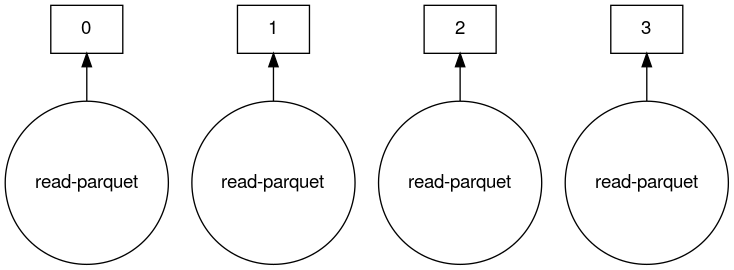

In [ ]:
df.visualize()

In [ ]:
len(df)

118914458

# Algumas operações de análise

Responda incluindo blocos de código neste arquivo de análise.

## Simples

Qual a empresa que tem mais vôos não cancelados?

In [ ]:
carriers = dd.read_csv("hdfs://schnorr@cei1.inf.ufrgs.br:9000/user/schnorr/carriers.csv")
carriers["UniqueCarrier"] = carriers["Code"]
df[(df["Cancelled"] == 0)] \
   .groupby(["UniqueCarrier"]) \
   .size() \
   .to_frame("Amount") \
   .reset_index() \
   .merge(carriers, on="UniqueCarrier") \
   .compute()

,UniqueCarrier,Amount,Code,Description
0,AA,14304048,AA,American Airlines Inc.
1,AS,2721018,AS,Alaska Airlines Inc.
2,CO,7839589,CO,Continental Air Lines Inc.
3,DL,15992728,DL,Delta Air Lines Inc.
4,EA,891083,EA,Eastern Air Lines Inc.
5,HP,3581251,HP,America West Airlines Inc. (Merged with US Air...
6,ML (1),69280,ML (1),Midway Airlines Inc. (1)
7,NW,9855119,NW,Northwest Airlines Inc.
8,PA (1),312646,PA (1),Pan American World Airways (1)
9,PI,865047,PI,Piedmont Aviation Inc.


Qual a `UniqueCarrier` que tem o maior atraso de chegada (`ArrDelay`)?

In [ ]:
df[(df["Cancelled"] == 0)] \
     .groupby("UniqueCarrier") \
     .ArrDelay \
     .max() \
     .compute()

UniqueCarrier
AA        1525.0
AS        1139.0
CO        1178.0
DL        1189.0
EA        1179.0
HP        1323.0
ML (1)     584.0
NW        2598.0
PA (1)    1438.0
PI        1381.0
PS        1033.0
TW         931.0
UA        1612.0
US        1073.0
WN         889.0
AQ        1024.0
B6        1392.0
DH        1438.0
EV        1187.0
FL         975.0
HA        1309.0
MQ        1357.0
OH        1380.0
OO        1435.0
TZ        1300.0
XE         939.0
9E        1942.0
F9         920.0
YV         715.0
Name: ArrDelay, dtype: float64

Qual o dia da semana que tem mais vôos?

In [ ]:
df[(df["Cancelled"] == 0)] \
    .groupby("DayOfWeek") \
    .size() \
    .compute()

DayOfWeek
1    17114412
2    17023604
3    17075451
4    17053551
5    17078261
6    15090192
7    16248655
dtype: int64

Qual a empresa que apresentar o maior número de cancelamentos?

In [ ]:
df[(df["Cancelled"] == 1)] \
    .groupby("UniqueCarrier") \
    .size() \
    .compute()

UniqueCarrier
AA        280233
AS         55786
CO        110446
DL        254620
EA         28702
HP         55431
ML (1)      1342
NW        212655
PA (1)      3521
PI          8910
PS          1151
TW         69088
UA        284581
US        287458
WN        147044
AQ          2837
B6          6978
DH         22176
EV         45996
FL         11521
HA           871
MQ        148107
OH         43330
OO         59727
TZ          2307
XE         45924
9E         12036
F9          1573
YV         25981
dtype: int64

Qual empresa que voou mais milhas?

In [ ]:
df[(df["Cancelled"] == 1)] \
    .groupby("UniqueCarrier") \
    .Distance \
    .sum() \
    .compute()

UniqueCarrier
AA        256777178.0
AS         38966023.0
CO         76069296.0
DL        167124321.0
EA         16605962.0
HP         40074304.0
ML (1)       783431.0
NW        126828042.0
PA (1)      1802664.0
PI          2937132.0
PS           397301.0
TW         42511917.0
UA        224865180.0
US        130910855.0
WN         58740495.0
AQ           737938.0
B6          6696547.0
DH          7775353.0
EV         19602473.0
FL          6872655.0
HA           308145.0
MQ         50605051.0
OH         19733400.0
OO         19567172.0
TZ          2228378.0
XE         20481428.0
9E          5245622.0
F9          1332021.0
YV          9612588.0
Name: Distance, dtype: float64

## Avançados

Qual a empresa `UniqueCarrier` que conseguiu recuperar melhor os atrasos durante o vôo?

In [ ]:
dft = df[(df["Cancelled"] == 0)][["UniqueCarrier", "DepDelay", "ArrDelay"]]
dft["Recover"] = dft["DepDelay"] - dft["ArrDelay"]
dft.groupby("UniqueCarrier")["Recover"] \
    .sum() \
    .compute()

UniqueCarrier
AA        14188223.0
AS         -847852.0
CO         4774662.0
DL         -107474.0
EA         1069979.0
HP         1830250.0
ML (1)       99868.0
NW         4712972.0
PA (1)        -947.0
PI        -1291282.0
PS          -36082.0
TW         2706018.0
UA        13242710.0
US        11711948.0
WN        50951634.0
AQ           65059.0
B6         1101018.0
DH         1884215.0
EV         4294812.0
FL          816250.0
HA          116280.0
MQ         1984844.0
OH         2591536.0
OO         3330662.0
TZ         -124519.0
XE        -1679247.0
9E          386791.0
F9          132375.0
YV         1158236.0
Name: Recover, dtype: float64

Há um crescimento no número de vôos?

In [ ]:
df[(df["Cancelled"] == 0)] \
    .groupby("Year") \
    .size() \
    .compute()

Year
1987    1292141
1988    5151933
1989    4967035
1990    5218435
1991    5033420
1992    5039321
1993    5010656
1994    5113308
1995    5235530
1996    5223447
1997    5314080
1998    5240212
1999    5373573
2000    5495557
2001    5736582
2002    5206216
2003    6387071
2004    7001513
2005    7006866
2006    7019988
2007    7292467
2008    2324775
dtype: int64

Qual empresa que apresenta uma redução no número de vôos?

In [ ]:
dft = df[(df["Cancelled"] == 0)][["UniqueCarrier", "Year", "Distance"]]
dft = dft.groupby(["UniqueCarrier", "Year"]) \
    .size()
# Continuar

Qual a época do ano que apresenta o maior cancelamento de vôos?

In [ ]:
df[(df["Cancelled"] == 1)] \
    .groupby("Month") \
    .size() \
    .compute()

Month
1     322248
2     248669
3     212262
4     125717
5     120589
6     155064
7     155926
8     156959
9     255148
10    131139
11    121207
12    225404
dtype: int64

## Livre

Faça uma consulta original para este dataset, potencialmente mais complexa que todas as anteriores.